# Comparison between Spatial Signatures and GHSL classes

In [1]:
import pandas
import geopandas
import rasterio
import rioxarray
import dask_geopandas
from rasterstats import zonal_stats
from geocube.api.core import make_geocube

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Global GHSL

Global file downloaded originally from [here](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_BUILT_C_GLOBE_R2022A/GHS_BUILT_C_MSZ_GLOBE_R2022A/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10/V1-0/).

In [2]:
ghsl_path = (
    '/home/jovyan/data/'
    'GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0/'
    'GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.tif'
)
ghsl = rasterio.open(ghsl_path)

In [3]:
ghsl = rioxarray.open_rasterio(
    ghsl_path, chunks=11000, cache=False
)

In [4]:
ghsl

,Array,Chunk
Bytes,5.91 TiB,115.39 MiB
Shape,"(1, 1800000, 3608200)","(1, 11000, 11000)"
Count,53957 Tasks,53956 Chunks
Type,uint8,numpy.ndarray


Read and parse the color file:

In [5]:
def parse_clr(p):
    with open(p) as fo:
        lines = fo.readlines()
    colors = pandas.DataFrame(
        map(parse_line, lines),
        columns=['code', 'color', 'name']
    )
    return colors
def parse_line(l):
    l = l.replace('\n', '').split(' ')
    code = l[0]
    rgba = tuple(map(int, l[1:5]))
    name = ' '.join(l[5:])
    return code, rgba, name
colors = parse_clr(
    '/home/jovyan/data/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0/'
    'GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.clr'
)

## Spatial Signatures

We use the officially released file with all detail (and a larger footprint) is available from the Figshare repository [here](https://figshare.com/articles/dataset/Geographical_Characterisation_of_British_Urban_Form_and_Function_using_the_Spatial_Signatures_Framework/16691575/2?file=36049196).

In [6]:
ss = geopandas.read_file(
    '/home/jovyan/data/spatial_signatures/'
    'spatial_signatures_GB.gpkg'
).to_crs(ghsl.rio.crs)

Build list of types to turn them into ints:

In [7]:
types = {i: j[1]['type'] for i, j in enumerate(
    ss[['code', 'type']].drop_duplicates().iterrows()
)}
types_r = {types[i]: i for i in types}
types

{0: 'Countryside agriculture',
 1: 'Accessible suburbia',
 2: 'Open sprawl',
 3: 'Wild countryside',
 4: 'Warehouse/Park land',
 5: 'Gridded residential quarters',
 6: 'Urban buffer',
 7: 'Disconnected suburbia',
 8: 'Dense residential neighbourhoods',
 9: 'Connected residential neighbourhoods',
 10: 'Dense urban neighbourhoods',
 11: 'Local urbanity',
 12: 'Concentrated urbanity',
 13: 'Regional urbanity',
 14: 'outlier',
 15: 'Metropolitan urbanity',
 16: 'Hyper concentrated urbanity'}

Add column with class int:

In [8]:
ss['code_no'] = ss['type'].map(types_r)

## Signature rasterisation

Following similar procedures (e.g., [here](validation)), we rasterise the signatures.

In [ ]:
%%time
rss = make_geocube(
    ss, 
    measurements=['code_no'], 
    like=ghsl.rio.clip_box(*ss.total_bounds)
)

In [10]:
rss

<xarray.Dataset>
Dimensions:      (y: 109923, x: 71322)
Coordinates:
  * y            (y) float64 6.959e+06 6.959e+06 ... 5.859e+06 5.859e+06
  * x            (x) float64 -5.837e+05 -5.837e+05 ... 1.295e+05 1.295e+05
    spatial_ref  int64 0
Data variables:
    *empty*

In [29]:
ghsl.rio.clip_box(*ss.total_bounds)

<xarray.DataArray (band: 1, y: 109923, x: 71322)>
dask.array<getitem, shape=(1, 109923, 71322), dtype=uint8, chunksize=(1, 11000, 11000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.837e+05 -5.837e+05 ... 1.295e+05 1.295e+05
  * y            (y) float64 6.959e+06 6.959e+06 ... 5.859e+06 5.859e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

## Overlap

In [8]:
from dask.distributed import Client, LocalCluster
client = Client(LocalCluster())
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40301,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.49 GiB
Comm: tcp://127.0.0.1:43373,Total threads: 4
Dashboard: http://127.0.0.1:35053/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:36899,


---

---

**DEPRECATED**

As of July 13th'22, the approaches below are deprecated because loading imagery for certain signature polygons is deemed unfeasible. The main issue is there are a few very large polygons:

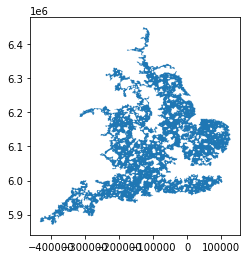

In [27]:
ssa = ss.area
ss[ssa == ssa.max()].plot();

- Single-core approach

In [64]:
%%time
stats = pandas.DataFrame(
    zonal_stats(ss.head(100), ghsl_path, categorical=True),
).reindex(columns=colors['code'].astype(int))

CPU times: user 3.14 s, sys: 15.1 s, total: 18.3 s
Wall time: 18.1 s


- Multi-core on `dask`

Move signatures to Dask:

In [11]:
ss_ddf = dask_geopandas.from_geopandas(
    ss, chunksize=1000
)
ss_ddf.spatial_shuffle()

,id,code,type,geometry
npartitions=97,,,,
245450365,object,object,object,geometry
304747790,...,...,...,...
...,...,...,...,...
4216674416,...,...,...,...
4254422608,...,...,...,...


Set up computation:

In [9]:
def do_zonal_stats(df):
    bb = 
    out = zonal_stats(df, ghsl_path, categorical=True)
    out = pandas.DataFrame(out).reindex(
        index=df.index,
        columns=colors['code'].astype(int)
    )
    return out

tmp = ss_ddf.map_partitions(
    do_zonal_stats,
    meta={int(c): 'int' for c in colors['code']}
)

In [ ]:
%%time
out = tmp.compute()

out.rename(columns=str).to_parquet(
    '/home/jovyan/data/spatial_signatures/cross_ghsl_c_msz.pq'
)

In [95]:
out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       0 non-null      float64
 1   2       1 non-null      float64
 2   3       3 non-null      float64
 3   4       0 non-null      float64
 4   5       0 non-null      float64
 5   11      3 non-null      float64
 6   12      0 non-null      float64
 7   13      0 non-null      float64
 8   14      0 non-null      float64
 9   15      0 non-null      float64
 10  21      0 non-null      float64
 11  22      0 non-null      float64
 12  23      0 non-null      float64
 13  24      0 non-null      float64
 14  25      0 non-null      float64
dtypes: float64(15)
memory usage: 11.8 KB


## Comparison